In [1]:
# Referencias:
#   - https://deepmimo.net/versions/v2-python/
#   - https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html
#   - https://medium.com/@nrk25693/how-to-add-your-conda-environment-to-your-jupyter-notebook-in-just-4-steps-abeab8b8d084

import DeepMIMO
import sys
print(sys.executable)


/home/charly/anaconda3/envs/pfc/bin/python


### Características del escenario: (https://deepmimo.net/scenarios/i2-scenario/)


- An indoor room scenario with dimensions 7 m x 13 m x 3 m
- A line-of-sight (LOS) blockage between the base station and the users
- One access point inside the room at 2 m height
- More than **140 thousand** candidate users
- Dataset is available at operating frequency 28 GHz


In [2]:
import pprint
import numpy as np

# Selección de parámetros:

# Load the default parameters
parameters = DeepMIMO.default_params()

# Set scenario name
parameters['scenario'] = 'I2_28B' # Escenario descargado

# Set the main folder containing extracted scenarios
parameters['dataset_folder'] = r'../scenarios'

# Elegimos las BS que queremos utilizar del escenario:
parameters['active_BS'] = np.array([1]) 

# Dynamic scenarios - Determines the range of dynamic scenario scenes to be loaded
# parameters['dynamic_settings']['first_scene'] = 1
# parameters['dynamic_settings']['last_scene'] = 4

# Activate frequency domain (FD) channel generation for OFDM systems:
parameters['activate_OFDM'] = 1

# To sample all 512 subcarriers without spacing:
parameters['OFDM']['subcarriers_limit'] = 512
parameters['OFDM']['subcarriers_sampling'] = 1

# Ponemos una antena en TX y una también en RX
parameters['bs_antenna']['shape'] = np.array([1,1,1])
parameters['ue_antenna']['shape'] = np.array([1,1,1])

# For raised cosine pulse shape with a roll-off factor 0.5
# raised cosine pulse shaping and matched filter with a roll-off factor defined by rolloff_factor float in [0, 1]
parameters['OFDM']['pulse_shaping'] = 2
parameters['OFDM']['rolloff_factor'] = 0.25

pp = pprint.PrettyPrinter(indent=4)
pp.pprint(parameters)

# Generate data
dataset = DeepMIMO.generate_data(parameters)

{   'OFDM': {   'RX_filter': 0,
                'bandwidth': 0.05,
                'pulse_shaping': 2,
                'rolloff_factor': 0.25,
                'subcarriers': 512,
                'subcarriers_limit': 512,
                'subcarriers_sampling': 1},
    'OFDM_channels': 1,
    'activate_OFDM': 1,
    'active_BS': array([1]),
    'bs_antenna': {   'radiation_pattern': 'isotropic',
                      'shape': array([1, 1, 1]),
                      'spacing': 0.5},
    'dataset_folder': '../scenarios',
    'dynamic_settings': {'first_scene': 1, 'last_scene': 1},
    'enable_BS2BS': 1,
    'num_paths': 5,
    'row_subsampling': 1,
    'scenario': 'I2_28B',
    'ue_antenna': {   'radiation_pattern': 'isotropic',
                      'shape': array([1, 1, 1]),
                      'spacing': 0.5},
    'user_row_first': 1,
    'user_row_last': 1,
    'user_subsampling': 1}

Basestation 1

UE-BS Channels


Generating channels: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:00<00:00, 2627.09it/s]



BS-BS Channels


Generating channels: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 555.91it/s]


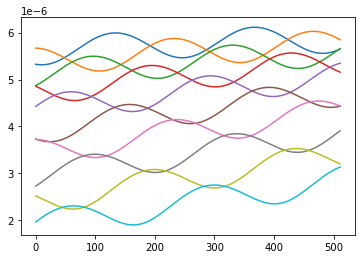

SNR en dBm:
[[57.38035905]
 [58.85894801]
 [68.67264095]
 [52.84721287]
 [52.57355758]
 [57.00265591]
 [47.92660185]
 [41.72256097]
 [46.62929844]
 [78.51694375]]


In [3]:
import matplotlib.pyplot as plt

# Cálculo del SNR:

bs = 0 # única bs disponible
RX_ant = 0 # única antena RX disponible
TX_ant = 0 # única antena TX disponible
SNR = np.zeros(shape = (10, 1))

for ue in range (0, 10): # Elegimos 10 usuarios de los 140k usuarios disponibles
    
    # Calculamos el SNR de la portadora a partir de la ganancia en cada frecuencia.

    # Channel magnitud response por portadora OFDM:
    info = np.absolute(dataset[bs]['user']['channel'][ue][RX_ant][TX_ant])

    # Plot Channel magnitud response por sub-portadora OFDM:
    plt.plot(info)

    # Estimar SNR por portadora OFDM:
    pot_i = 10**(-1) # Potencia de cada sub portadora en transmisión (W)
    N_0 = abs(10**(-16)*np.random.randn()) # Nivel de ruido 
    B = parameters['OFDM']['bandwidth'] * (10**9) # Ancho de banda del canal OFDM

    # SNR portadora:
    pot_senal = 0
    for subp in range(0,512):
        pot_senal += pot_i * (info[subp]**2)
    SNR[ue] = pot_senal / (N_0 * B)

plt.show()
np.save("SNRs", SNR)
print(f"SNR en dBm:\n{10*np.log(SNR*1000)}")


In [4]:
# Cargamos el archivo guardado anteriormente:

SNRs_abierto = np.load("SNRs.npy")
print(SNRs_abierto)

[[0.31045405]
 [0.35992469]
 [0.96031763]
 [0.19729919]
 [0.1919732 ]
 [0.29894679]
 [0.12062182]
 [0.06486162]
 [0.10594603]
 [2.57008532]]


In [5]:
# The combined path-loss of the channel between the RX and TX in dBm.
pathloss = [dataset[bs]['user']['pathloss'][ue] for ue in range(0,10)]
print(f"Path loss en dbm:\n{np.array(pathloss)}")

# Aclaración: no estamos usando el pathloss para el modelado del canal.

Path loss en dbm:
[82.95559692 81.78170013 82.81770325 83.80059814 84.01200104 86.85749817
 84.8809967  88.56020355 89.29299927 91.85379791]


In [6]:
# Información de los diferentes caminos entre BS y UE
pp.pprint(dataset[0]['user']['paths'][0])

{   'DoA_phi': array([-137.962, -136.819, -137.962,  106.579, -136.819], dtype=float32),
    'DoA_theta': array([ 82.9999,  83.128 , 110.222 ,  81.9449, 109.878 ], dtype=float32),
    'DoD_phi': array([ 137.502, -136.359,  137.502,  106.119, -136.359], dtype=float32),
    'DoD_theta': array([ 97.0001,  96.872 , 110.222 ,  81.9449, 109.878 ], dtype=float32),
    'ToA': array([2.73790e-08, 2.78869e-08, 2.89600e-08, 7.14374e-08, 2.94406e-08],
      dtype=float32),
    'num_paths': 5,
    'phase': array([-79.9027 ,   7.03146, -39.7233 , 150.401  , -38.3708 ],
      dtype=float32),
    'power': array([7.5533650e-09, 2.0994724e-09, 4.1816750e-10, 4.5404586e-11,
       4.2364282e-11], dtype=float32)}
